In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# 2a
# read file
data = np.load('volcano_InSAR.npz')

# Or iterate through all arrays
for key in data.files:
    print(f"{key}: {data[key].shape}")

X: (21596, 226, 226)
Y: (21596,)


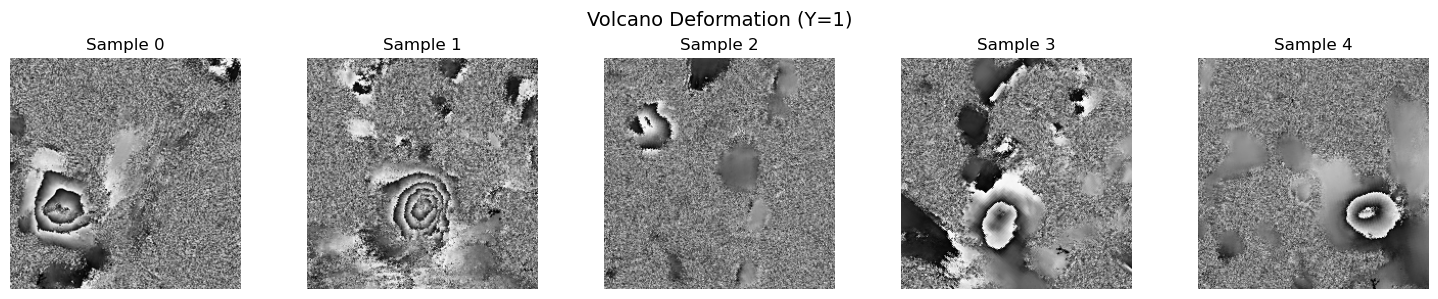

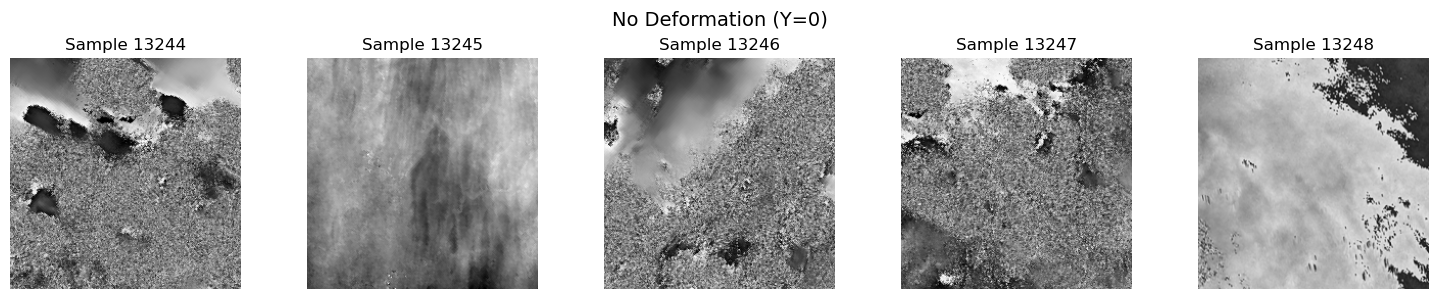

In [5]:
# plot
# Load images and labels (adjust key names based on actual file)
X = data['X'] 
Y = data['Y'] 

idx_deformation = np.where(Y == 1)[0]
idx_no_deformation = np.where(Y == 0)[0]

samples_y1 = idx_deformation[:5]
samples_y0 = idx_no_deformation[:5]

# Plot 5 images with Y=1
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('Volcano Deformation (Y=1)', fontsize=14)
for i, idx in enumerate(samples_y1):
    axes[i].imshow(X[idx].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {idx}')
plt.tight_layout()
plt.show()

# Plot 5 images with Y=0
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('No Deformation (Y=0)', fontsize=14)
for i, idx in enumerate(samples_y0):
    axes[i].imshow(X[idx].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {idx}')
plt.tight_layout()
plt.show()

In [6]:
# 2b - normalizing each image separately
def norm_max_min(img):
    val_max = np.nanmax(img)
    val_min = np.nanmin(img)
    img_scaled = (img - val_min) / (val_max - val_min)
    return img_scaled

In [7]:
X_scaled = np.zeros(X.shape)
n_sample = len(Y)
for i in range(n_sample):
    X_scaled[i] = norm_max_min(X[i])

In [23]:
# 2c build a PyTorch dataset
class VolcanoDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
        
# Create dataset
dataset = VolcanoDataset(X_scaled, Y)

In [29]:
# split data: 75% for training, 25% for testing
split_ratio = 0.75
train_size  = int(split_ratio * len(dataset))
test_size   = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [30]:
# convert to DataLoader
train_DataLoader = torch.utils.data.DataLoader(train_dataset.dataset, batch_size=None, shuffle=True)
test_DataLoader  = torch.utils.data.DataLoader(test_dataset.dataset, batch_size=None,  shuffle=False)

In [ ]:
# 2d - build a model
p = 0.3  # dropout rate
MaxPool_size = 2   # pooling window
channel_num  = 8   # number of channels for each conv layer
kernel_size  = 5   # kernel size for each conv layer
neuron_num1  = 128
neuron_num2  = 1

class VolcanoCNN1(torch.nn.Module):
    def __init__(self, p, MaxPool_size, channel_num, kernel_size, neuron_num1, neuron_num2):
        super(VolcanoCNN1, self).__init__()
        # conv layers, no padding
        self.conv = torch.nn.Conv2d(1, channel_num, kernel_size=kernel_size)
        # dropout
        self.dropout = torch.nn.Dropout(p=p)
        # max pooling
        self.maxpool = torch.nn.MaxPool2d(kernel_size=MaxPool_size)
        # dense layers
        # self.fc1 = torch.nn.Linear(channel_num * 12 * 12, nueron_num1)
        self.fc2 = torch.nn.Linear(neuron_num1, neuron_num2)
        # activation
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # combine into sequential
        self.NN_relu_stack = nn.Sequential(
            self.conv,
            self.relu,
            self.maxpool,
            self.dropout
        )

    def forward(self, x):
        # conv - Relu - maxpool - dropout
        for i in range(5):
            print(i)
            x = self.NN_relu_stack(x)
            
        # flatten
        x = x.view(x.size(0), -1)

        # dynamic layer 
        self.fc1 = torch.nn.Linear(x.size(1), neuron_num1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # dense layer 2
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [38]:
# set up model
model1 = VolcanoCNN1(p, MaxPool_size, channel_num, kernel_size, neuron_num1, neuron_num2)
model1 = model1.to(device)

In [45]:
# 2e - set up optimizer
optimizer = torch.optim.Adam(model1.parameters())
criterion = torch.nn.BCELoss()

In [ ]:
# 2f - write a class to train the model